In [23]:
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import matplotlib.cm as cm
import cPickle as pickle
import helpers
import plots
import pandas as pd
import glob
import plot_ts
reload(plots)
reload(helpers)

<module 'helpers' from 'helpers.pyc'>

# Figure 1 notebook

In [24]:
## Load posterior mean dataframe
df = pickle.load(open('pm_df.p', 'rb'))
print df.dtypes

theta1      float64
theta2      float64
theta3      float64
theta4      float64
theta5      float64
theta6      float64
theta7      float64
theta8      float64
drug         object
dose        float64
adlib        object
period       object
id            int64
duration      int64
filename     object
filepath     object
rate        float64
x0           object
drug_c       object
rate_c       object
ms           object
dtype: object


## Figure 1B: Stomach fullness is highly indicative of feeding behaviour and can be used to predict the intermeal interval

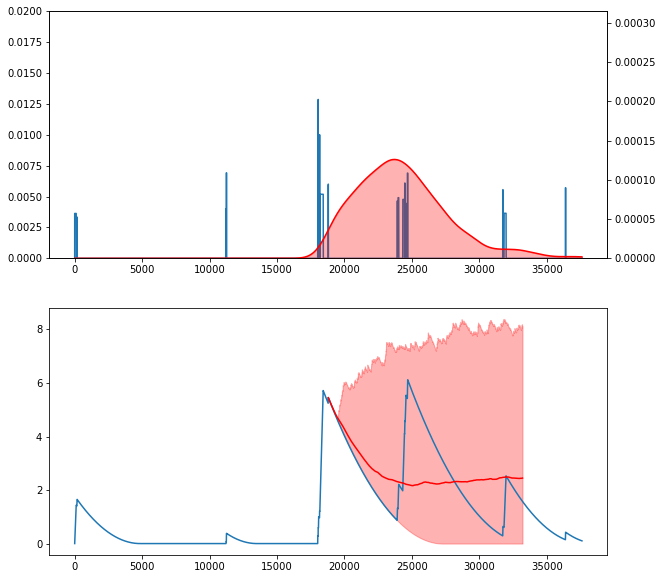

In [28]:
reload(plots)
import fwd_likelihoods as fl
reload(fl)
## Sampling parameters
predict_index = 10 # 10 is good
num_samples = 1000
tmax = 4*60*60

## Get subject data
subj_file = 'saline_0.0_A_L_5_10_2015-11-23.B0105.CSV'
subj_path = '_'.join(subj_file.split('_')[:4])
subj_path = 'new_all_data/' + subj_path + '/'
filepath = subj_path + subj_file
data = np.loadtxt(filepath, delimiter='\t', usecols=(0,1,2,3,4))

## Get subject posterior
post_info = subj_file.split('_')

idx1 = (df['drug'] == post_info[0]) & (df['dose'] == float(post_info[1]))
idx2 = (df['adlib'] == post_info[2]) & (df['period'] == post_info[3])
idx3 = (df['id'] == int(post_info[4]))
animal_df = df[idx1 & idx2 &idx3]

## Convert from transformed parameters
thetas = ['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8']
pm_theta = np.array(animal_df[thetas])[0]
theta7 = np.power(10., np.array(animal_df['theta7'])[0])
theta8 = np.power(10., np.array(animal_df['theta8'])[0])

## Do the plotting
fig, axes = plots.timeseries_predict_plot(data, 
                                          pm_theta,
                                          predict_index, 
                                          num_samples,
                                          tmax)
plt.show()

## Figure 1C: Model fit to microscopic feeding behaviour yields long-term calorie intakes that match those observed across a range of nutritional states, anorectic drugs and photoperiods

0.620596611471 0.00398566933427


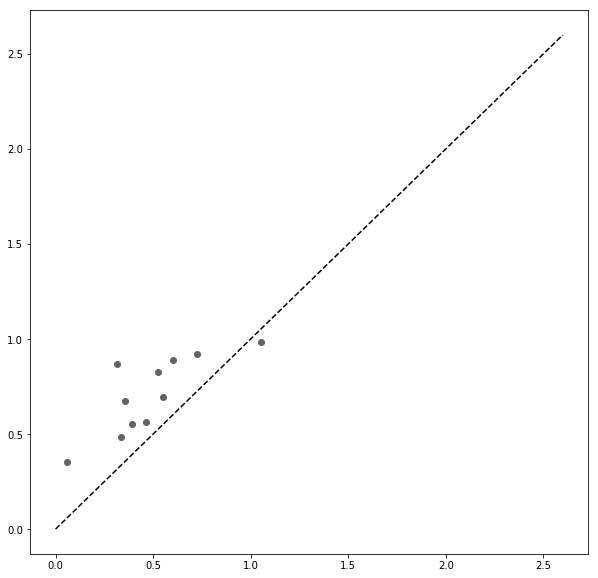

In [27]:
import fwd_sample as fs
import scipy
reload(plots)
reload(fs)

num_samples = 1000

fig, axes = plt.subplots(1, figsize=(10,10))

true_vals = []
post_predicts = []

## Posterior predictive check function
def ppc(row):
    theta = np.array(row[thetas])
    duration = row['duration']
    rate = row['rate']
    c = row['drug_c']
    ms = row['ms']
    x0 = float(row['x0'])
    
    samples = []
    for i in range(0, num_samples):
        samples.append(fs.sample(3600*duration, theta, x0)[1])
        
    samples = np.array(samples)
    post_predict = np.mean(samples/duration)
    axes.scatter(rate, post_predict, c=c, marker=ms)
    ppc_err = np.std(samples/duration)
    """
    axes.errorbar(rate, 
                  post_predict, 
                  yerr=ppc_err, 
                  fmt='o',
                  ecolor=c, 
                  color=c, 
                  marker=ms)    
    """
    
    ## Could do errorbar with SEM?
    true_vals.append(rate)
    post_predicts.append(post_predict)
    
# Iterate through the posterior means and plot
df.apply(ppc, axis=1)

## Visual guide for accuracy
x = np.linspace(0, 2.6, 10)
axes.plot(x, x, c='k', ls='--')

## Goodness of fit check
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(true_vals, post_predicts)
print r_value**2, p_value

plt.show()